Build a Deep Feed Forward ANN by implementing the Backpropagation algorithm and test the same using appropriate data sets. Use the number of hidden layers >=4.

Epoch 0 | Loss: 2.7336
Epoch 100 | Loss: 1.0984
Epoch 200 | Loss: 1.0984
Epoch 300 | Loss: 1.0984
Epoch 400 | Loss: 1.0984
Epoch 500 | Loss: 1.0984
Epoch 600 | Loss: 1.0984
Epoch 700 | Loss: 1.0984
Epoch 800 | Loss: 1.0984
Epoch 900 | Loss: 1.0984

Test Accuracy: 30.00%


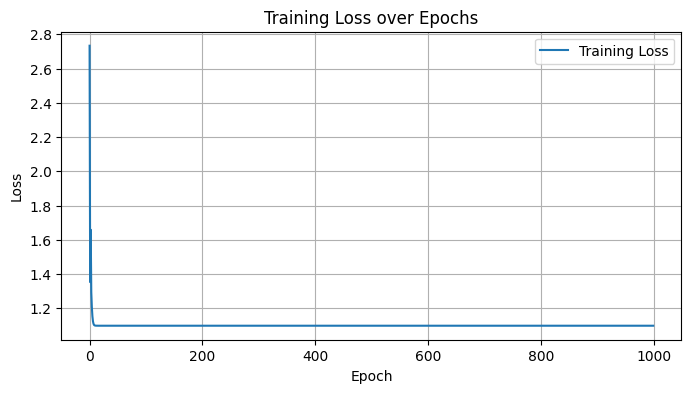

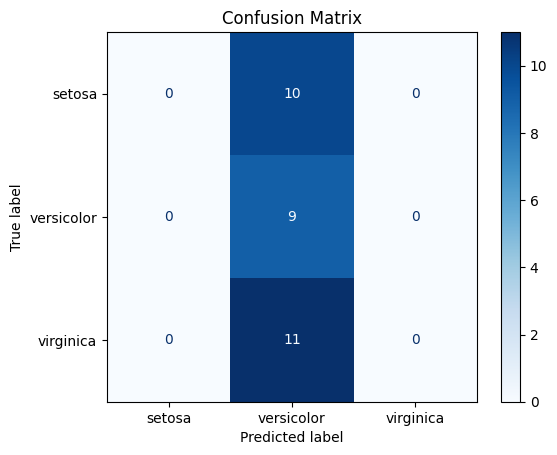

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------ Data Preprocessing ------------------
# Load the dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Activation Functions ------------------
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# ------------------ Loss Functions ------------------
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

# ------------------ Deep ANN Implementation ------------------
class DeepANN:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.lr = learning_rate
        self.weights = []
        self.biases = []
        self.loss_history = []

        # Initialize weights and biases
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2. / layer_sizes[i])
            bias = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)

    def forward(self, X):
        activations = [X]
        zs = []

        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            zs.append(z)
            a = relu(z)
            activations.append(a)

        # Output layer with softmax
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        zs.append(z)
        a = softmax(z)
        activations.append(a)

        return activations, zs

    def backward(self, activations, zs, y_true):
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        # Output layer
        delta = cross_entropy_derivative(y_true, activations[-1])
        grads_w[-1] = np.dot(activations[-2].T, delta)
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # Hidden layers
        for i in reversed(range(len(grads_w) - 1)):
            delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(zs[i])
            grads_w[i] = np.dot(activations[i].T, delta)
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            activations, zs = self.forward(X)
            loss = cross_entropy_loss(y, activations[-1])
            self.loss_history.append(loss)
            self.backward(activations, zs, y)

            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

    def accuracy(self, X, y_true):
        preds = self.predict(X)
        labels = np.argmax(y_true, axis=1)
        return np.mean(preds == labels)

# ------------------ Model Setup ------------------
# 4 hidden layers + input(4) and output(3)
layer_sizes = [4, 16, 32, 16, 8, 3]
model = DeepANN(layer_sizes, learning_rate=0.01)

# Train the model
model.train(X_train, y_train, epochs=1000)

# Test accuracy
acc = model.accuracy(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

# ------------------ Plot Training Loss ------------------
plt.figure(figsize=(8, 4))
plt.plot(model.loss_history, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ------------------ Confusion Matrix ------------------
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
